# HMS-HBA Fastai Training - Spectrogram Images
* 1/23/24: Generated an image dataset of spectrogram parquet files converted to log spectrograms
    * This dataset has images saved for all votes (so will be multiples)
    * Generate a set with just max vote and try again (or using expert consensus)
* This notebook is for training on the generated datasets.
    * Assumes folder structure is set up
    * Assumes bad image rejection is already done.
* Later switch to Keras/TensorFlow for more flexibility
    

# Installs

In [1]:
!pip install -q scienceplots

# Imports

In [2]:
import os
import cv2
import glob
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scienceplots
plt.style.use(['science','no-latex'])

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import fastai
from fastai.vision.all import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Unzip the Generated Spectrogram Files
* Loading zipfile from dataset takes ~10 min, then a few more to unzip the ~160K files, 13GB
* Look into saving as compact numpy arrays instead of .pngs, then convert here.
    * Save 1 channel will reduce by 3x, then can duplicate 3x to get image format below
   

In [3]:
%%time
if not os.path.exists('/kaggle/working/spectrograms/'):
    !unzip -q /kaggle/input/hms-hba-generate-spectrogram-image-files/_output_.zip

CPU times: user 2.45 s, sys: 527 ms, total: 2.98 s
Wall time: 2min 58s


# Set paths

In [4]:
kaggle = True
root_dir = '.'
if kaggle:
    root_dir = '/kaggle/input/hms-harmful-brain-activity-classification'
    
spect_dir = '/kaggle/working/spectrograms/'
train = pd.read_csv(root_dir + '/train.csv')
train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
targets = [col for col in train.columns if '_vote' in col]
targets

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

# Add path to train.csv
* acutally not sure I need to use train.csv at all, I have already put the files in with labels, so just need to train...

In [6]:
# make lists of files to save processing time
seizure_files = glob.glob('/kaggle/working/spectrograms/seizure_vote/*.*')
lpd_files = glob.glob('/kaggle/working/spectrograms/lpd_vote/*.*')
gpd_files = glob.glob('/kaggle/working/spectrograms/gpd_vote/*.*')
lrda_files = glob.glob('/kaggle/working/spectrograms/lrda_vote/*.*')
grda_files = glob.glob('/kaggle/working/spectrograms/grda_vote/*.*')
other_files = glob.glob('/kaggle/working/spectrograms/other_vote/*.*')
all_files = seizure_files + lpd_files + gpd_files + lrda_files + grda_files + other_files


# Fast.ai Training

In [7]:
# list of supported models in fastai
print([mdl for mdl in dir(fastai.vision.models) if '__' not in mdl])

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

# Set image path and create DataBlock
* 80/20 train/validation split
* resize to 256
    * maybe should do 224 instead

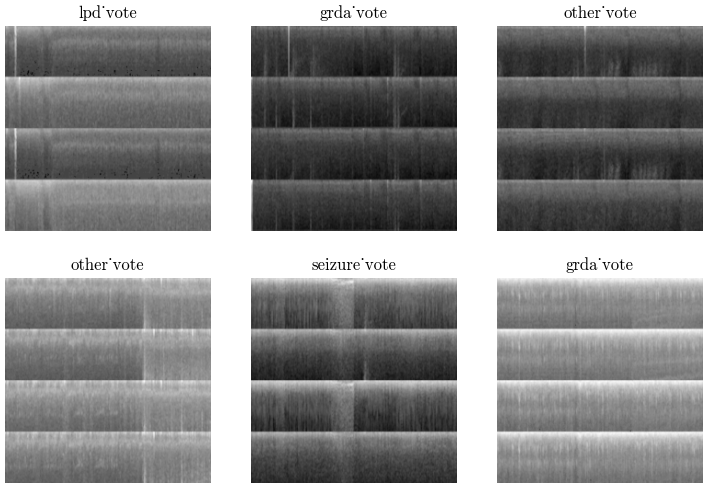

In [8]:
path = Path(spect_dir)

# data block is key with fast.ai
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
    get_items = get_image_files,   #returns a list of all images files path
    splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set
    get_y = parent_label,   # set label to parent directory
    item_tfms=[Resize(224, method='squish')]  # most architectures need all images the same size
).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.

dls.show_batch(max_n=6) # shows the input (picture) and the label


## Set Architecture, Metrics and Epochs

In [32]:
learn = vision_learner(dls,resnet50,metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.528633,1.470429,0.381086,11:58


epoch,train_loss,valid_loss,accuracy,time
0,1.290809,1.229102,0.458945,15:32
1,1.106877,1.093675,0.472438,15:35
2,0.988075,1.062059,0.439163,15:35


In [33]:
learn.dls.vocab

['gpd_vote', 'grda_vote', 'lpd_vote', 'lrda_vote', 'other_vote', 'seizure_vote']

In [34]:
#learn.lr_find()

In [35]:
today = datetime.today().strftime('%y-%m-%d')
learn.export(f'{today}_hms-hba-resnet50_3_epochs_acc.pkl')

## Visualize Results

In [36]:
seizure_files[0]

'/kaggle/working/spectrograms/seizure_vote/1390118961_4.png'

The model predicts: lpd_vote with probability: 0.5260


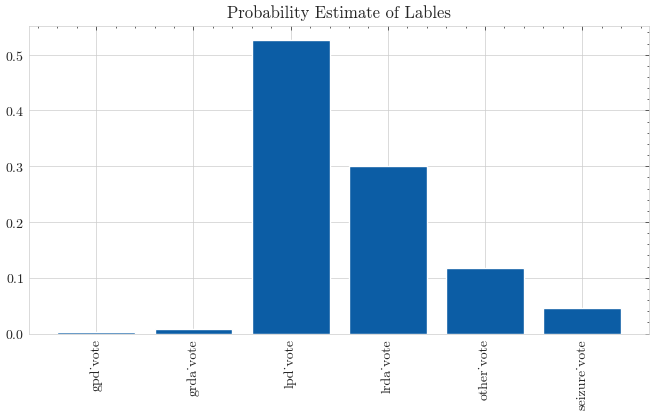

In [37]:
im = cv2.imread(f'{lrda_files[0]}')

pred,pred_idx,probs = learn.predict(im)
print(f'The model predicts: {pred} with probability: {probs[pred_idx]:.4f}')

plt.figure(figsize=(8,4))
plt.bar(learn.dls.vocab,np.asarray(probs))
# sns.barplot(x=learn.dls.vocab,y=np.asarray(probs))  # why does sns barplot not work?
plt.xticks(rotation=90)
plt.title('Probability Estimate of Lables');

In [38]:
print(learn.dls.vocab)
print(probs)

['gpd_vote', 'grda_vote', 'lpd_vote', 'lrda_vote', 'other_vote', 'seizure_vote']
tensor([0.0025, 0.0078, 0.5260, 0.3001, 0.1175, 0.0461])
